In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.api as sm

sns.set_theme()
sns.set_context("talk")
sns.set_palette("colorblind")

colors = sns.color_palette("colorblind")
date_form = DateFormatter("%Y-%m-%d\n%H:%M")


In [81]:
sml_lt_df = pd.read_csv("Data/SML LT 2001.csv")
sml_lt_df['Date_UTC'] = pd.to_datetime(sml_lt_df['Date_UTC'])

sme_df = pd.read_csv("Data/SME 2001.csv")
sme_df['Date_UTC'] = pd.to_datetime(sme_df['Date_UTC'])

ng2011df = pd.read_csv("Data/substorms-newell-20000101_000000_to_20070101_000000.csv")
ng2011df['Date_UTC'] = pd.to_datetime(ng2011df['Date_UTC'])
ng2011_2001 = ng2011df[ng2011df['Date_UTC'].dt.year == 2001].reset_index(drop=True)

In [82]:
no_sectors = 7
MLT_sectors = np.concatenate([np.arange((24-np.floor(no_sectors/2)), 24), np.arange(0, no_sectors/2)]).ravel().astype(int)
allsec = [i for i in np.arange(0,24)]
allsec_names = [f'SMLr{i:02d}' for i in allsec]
MLT_sec_names =  [f'SMLr{i:02d}' for i in MLT_sectors]
SMLnightdf = pd.DataFrame({'Date_UTC':sml_lt_df['Date_UTC'],'SMLnight':sml_lt_df[MLT_sec_names].min(axis=1)})
SMLalldf = pd.DataFrame({'Date_UTC':sml_lt_df['Date_UTC'],'SMLall':sml_lt_df[allsec_names].min(axis=1)})

In [83]:
smlnight_scaled =((SMLnightdf['SMLnight'] - SMLnightdf['SMLnight'].mean())/SMLnightdf['SMLnight'].std()).to_numpy()
sml_scaled = ((sme_df['SML'] - sme_df['SML'].mean())/sme_df['SML'].std()).to_numpy()


## Descriptive statistics of the SML nightside modification

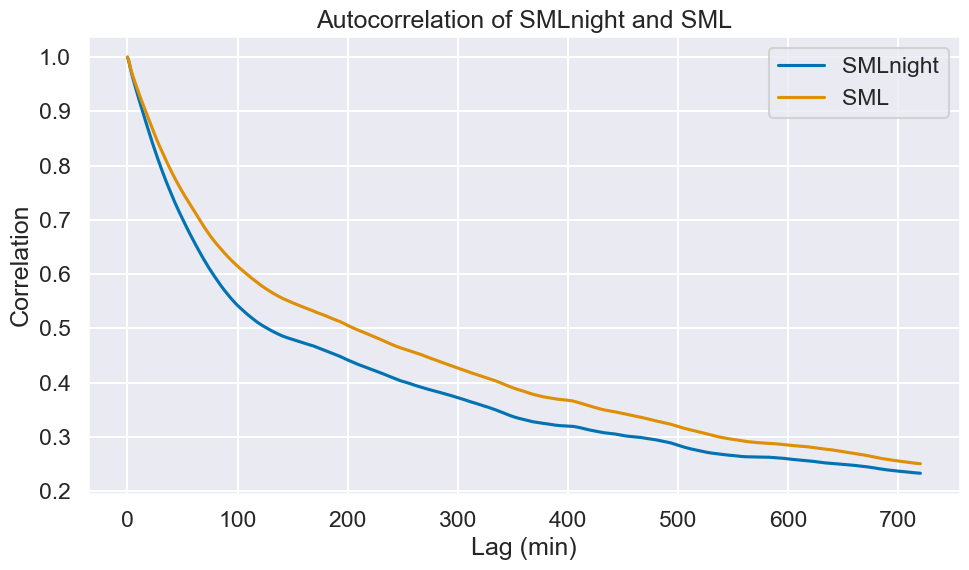

In [84]:
sml5_acorr = sm.tsa.stattools.acf(smlnight_scaled, nlags=12*60)
sml_acorr = sm.tsa.stattools.acf(sml_scaled, nlags=12*60)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sml5_acorr, label='SMLnight')
ax.plot(sml_acorr, label='SML')
ax.set_xlabel('Lag (min)')
ax.set_ylabel('Correlation')
ax.legend()
ax.set_title('Autocorrelation of SMLnight and SML')

plt.tight_layout(pad=1)

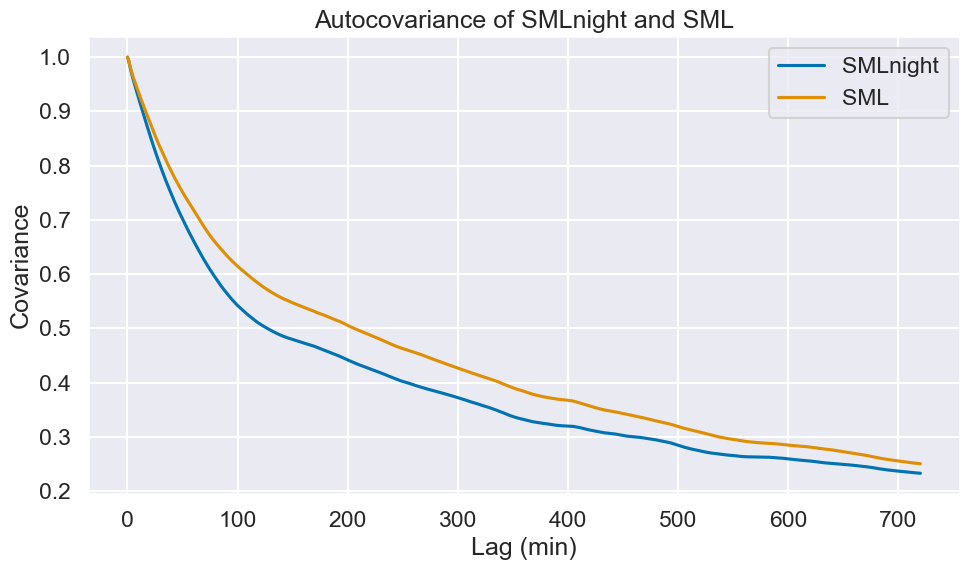

In [85]:
sml5_acov = sm.tsa.stattools.acovf(smlnight_scaled, nlag=12*60)
sml_acov = sm.tsa.stattools.acovf(sml_scaled, nlag=12*60)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sml5_acov, label='SMLnight')
ax.plot(sml_acov, label='SML')
ax.set_xlabel('Lag (min)')
ax.set_ylabel('Covariance')
ax.legend()
ax.set_title('Autocovariance of SMLnight and SML')

plt.tight_layout(pad=1)

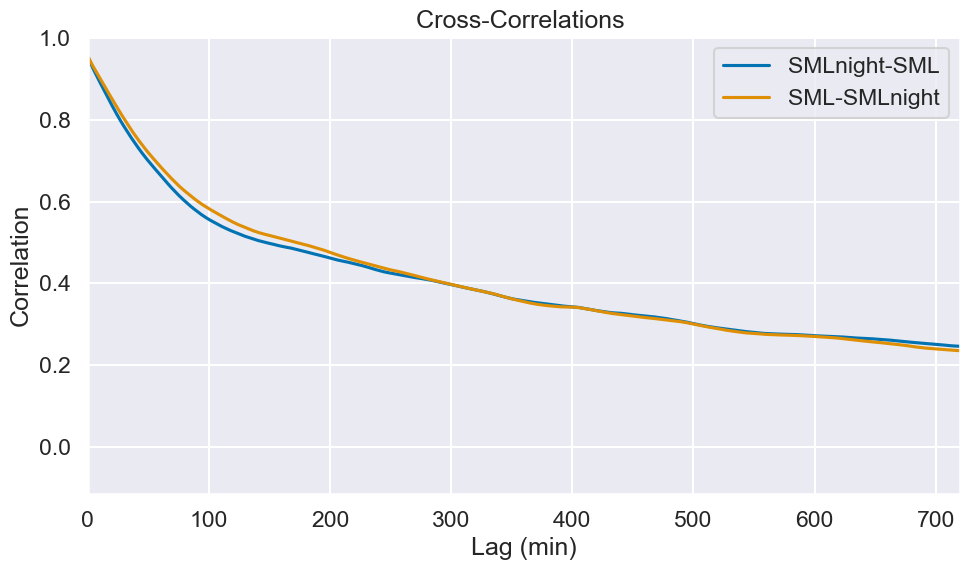

In [86]:
sml5_ccorr = sm.tsa.ccf(smlnight_scaled, sml_scaled, adjusted=False)
sml_ccorr = sm.tsa.ccf(sml_scaled, smlnight_scaled, adjusted=False)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sml5_ccorr, label='SMLnight-SML')
ax.plot(sml_ccorr, label='SML-SMLnight')
ax.set_xlabel('Lag (min)')
ax.set_ylabel('Correlation')
ax.legend()
ax.set_title('Cross-Correlations ')
ax.set_xlim(0, 12*60)
plt.tight_layout(pad=1)


## Substorm Identification on the new SMLnightside

In [87]:
onsettimes = []
onsetsectors = []
sml_array = sml_lt_df[MLT_sec_names].values

untilnext = 0
for index, __ in SMLnightdf[:-30].iterrows():
    onsettime = SMLnightdf['Date_UTC'][index]
    onsetsml = SMLnightdf['SMLnight'][index]
    onsetsector = np.where(sml_array[index]==onsetsml)[0]
    if untilnext > 1:
        untilnext -= 1
        continue
    if (SMLnightdf['SMLnight'][index + 1] - onsetsml) < -15:
        if (SMLnightdf['SMLnight'][index + 2] - onsetsml) < -30:
            if (SMLnightdf['SMLnight'][index + 3] - onsetsml) < -45:
                if np.sum(SMLnightdf['SMLnight'][index + 4:index + 30])/26 - onsetsml < -100:
                    onsettimes.append(onsettime)
                    onsetsectors.append(', '.join([str(element) for element in MLT_sectors[onsetsector]]))
                    untilnext = 20
    else:
        untilnext -= 1
        
ng2011_night = pd.DataFrame({'Date_UTC':onsettimes, 'MLT at onset':onsetsectors})

In [88]:
ng2011_night

,Date_UTC,MLT at onset
0,2001-01-01 06:23:00,"22, 23, 0"
1,2001-01-02 18:16:00,"22, 23, 0"
2,2001-01-02 22:24:00,"22, 23, 0"
3,2001-01-03 02:56:00,"1, 2, 3"
4,2001-01-03 11:03:00,"23, 0, 1"
...,...,...
1467,2001-12-31 09:24:00,"21, 22, 23"
1468,2001-12-31 16:23:00,3
1469,2001-12-31 18:01:00,"2, 3"
1470,2001-12-31 19:38:00,3


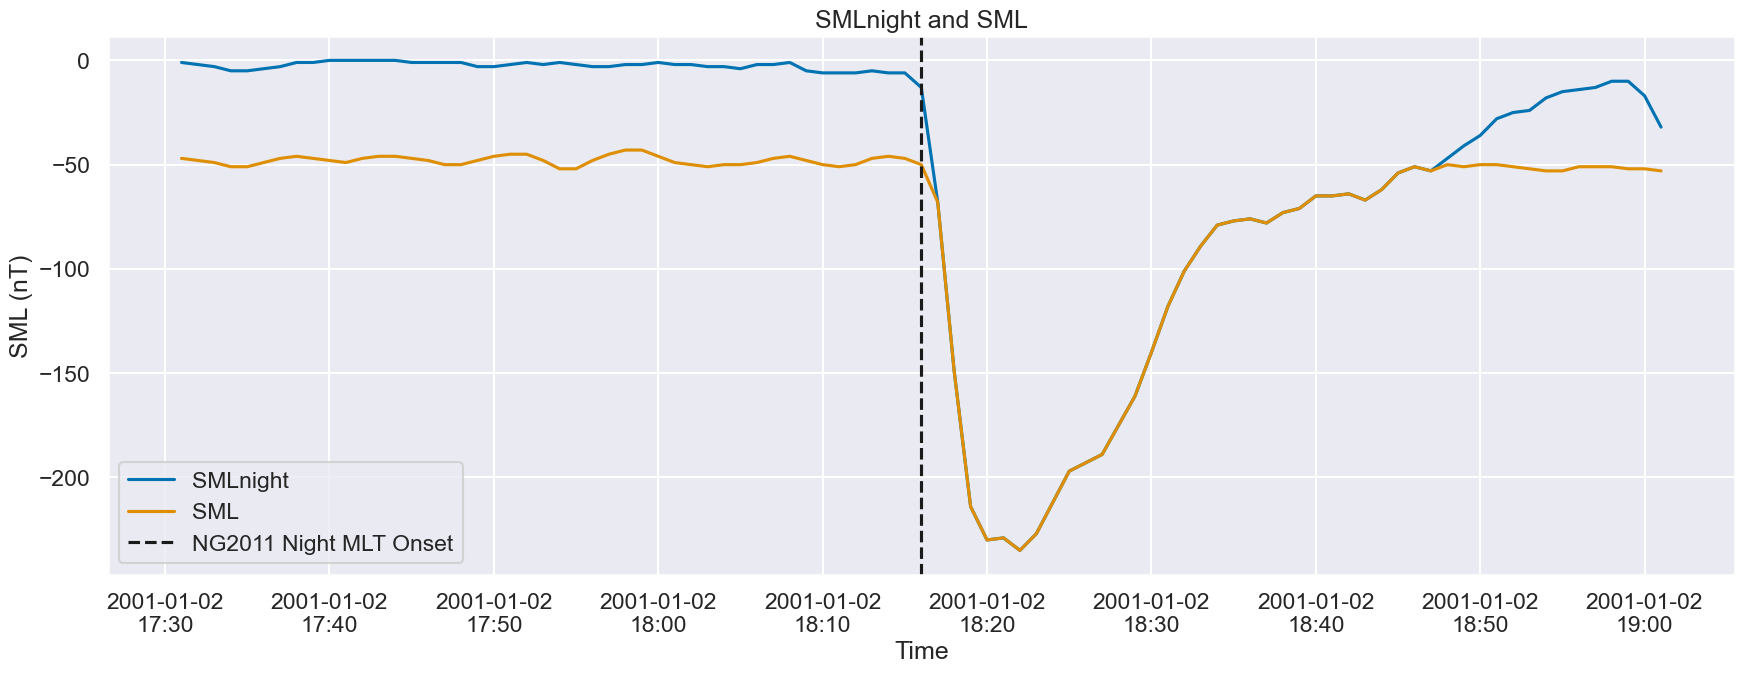

In [89]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_night['Date_UTC'], ng2011_2001['Date_UTC'])[0]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLnightdf['Date_UTC'][SMLnightdf['Date_UTC'].between(tstart,tend)]
y = SMLnightdf['SMLnight'][SMLnightdf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLnight')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k',ls='--',label='NG2011 Night MLT Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('SMLnight and SML')
ax.xaxis.set_major_formatter(date_form)

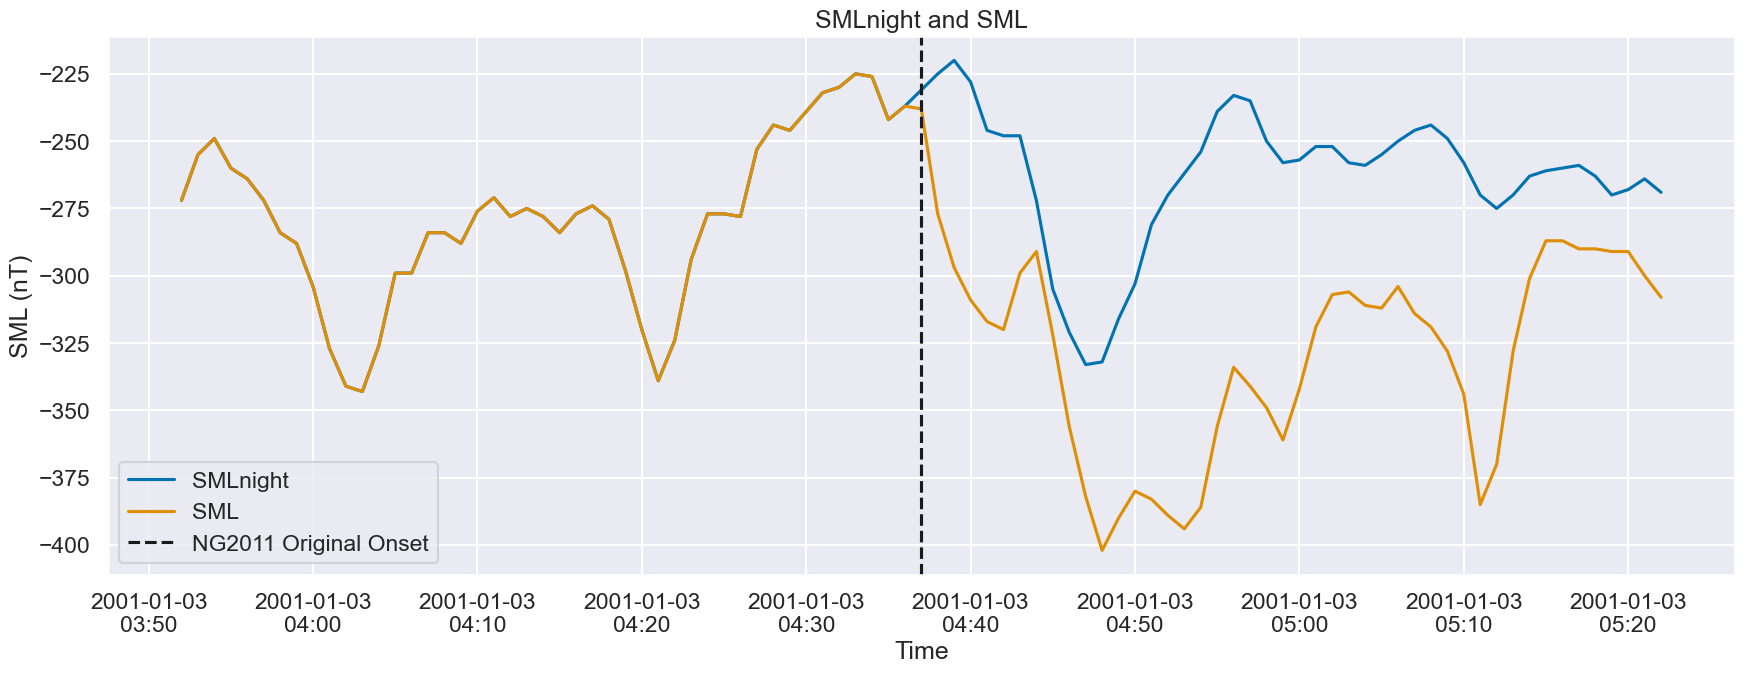

In [90]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_2001['Date_UTC'], ng2011_night['Date_UTC'])[0]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLnightdf['Date_UTC'][SMLnightdf['Date_UTC'].between(tstart,tend)]
y = SMLnightdf['SMLnight'][SMLnightdf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLnight')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k', ls='--', label='NG2011 Original Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('SMLnight and SML')
ax.xaxis.set_major_formatter(date_form)

## Recreating the NG2011 Substorm onset algorithm

In [91]:
onsettimes = []
onsetsectors = []
sml_array = sml_lt_df[allsec_names].values

untilnext = 0
for index, __ in SMLalldf[:-30].iterrows():
    onsettime = SMLalldf['Date_UTC'][index]
    onsetsml = SMLalldf['SMLall'][index]
    onsetsector = np.where(sml_array[index]==onsetsml)[0]
    if untilnext > 1:
        untilnext -= 1
        continue
    if SMLalldf['SMLall'][index + 1] - onsetsml < -15:
        if SMLalldf['SMLall'][index + 2] - onsetsml < -30:
            if SMLalldf['SMLall'][index + 3] - onsetsml <= -45:
                if np.sum(SMLalldf['SMLall'][index + 4:index + 30])/26 - onsetsml < -100:
                    onsettimes.append(onsettime)
                    onsetsectors.append(', '.join([str(element) for element in onsetsector]))
                    untilnext = 20
    else:
        untilnext -= 1
        
ng2011_all = pd.DataFrame({'Date_UTC':onsettimes, 'MLT at onset':onsetsectors})

In [92]:
ng2011_all

,Date_UTC,MLT at onset
0,2001-01-01 06:23:00,"18, 19, 20"
1,2001-01-02 22:24:00,"0, 22, 23"
2,2001-01-03 02:56:00,"1, 2, 3"
3,2001-01-03 04:37:00,"4, 5, 6"
4,2001-01-03 11:03:00,"0, 1, 23"
...,...,...
1564,2001-12-31 16:23:00,"3, 4, 5"
1565,2001-12-31 18:14:00,"19, 20, 21"
1566,2001-12-31 18:53:00,"6, 7, 8"
1567,2001-12-31 20:39:00,"4, 5, 6"


In [93]:
ng2011_2001

,Date_UTC,MLT,MLAT,GLON,GLAT
0,2001-01-01 06:23:00,23.92,71.19,265.95,61.11
1,2001-01-02 22:24:00,0.18,65.86,20.77,69.06
2,2001-01-03 02:56:00,2.45,64.87,338.30,64.18
3,2001-01-03 04:37:00,5.37,70.23,351.30,70.90
4,2001-01-03 11:03:00,0.09,65.59,212.57,65.12
...,...,...,...,...,...
1574,2001-12-31 16:23:00,4.44,70.25,203.38,71.32
1575,2001-12-31 18:14:00,20.45,71.50,19.20,74.50
1576,2001-12-31 18:53:00,7.40,71.19,216.35,70.14
1577,2001-12-31 20:39:00,9.10,71.19,216.35,70.14


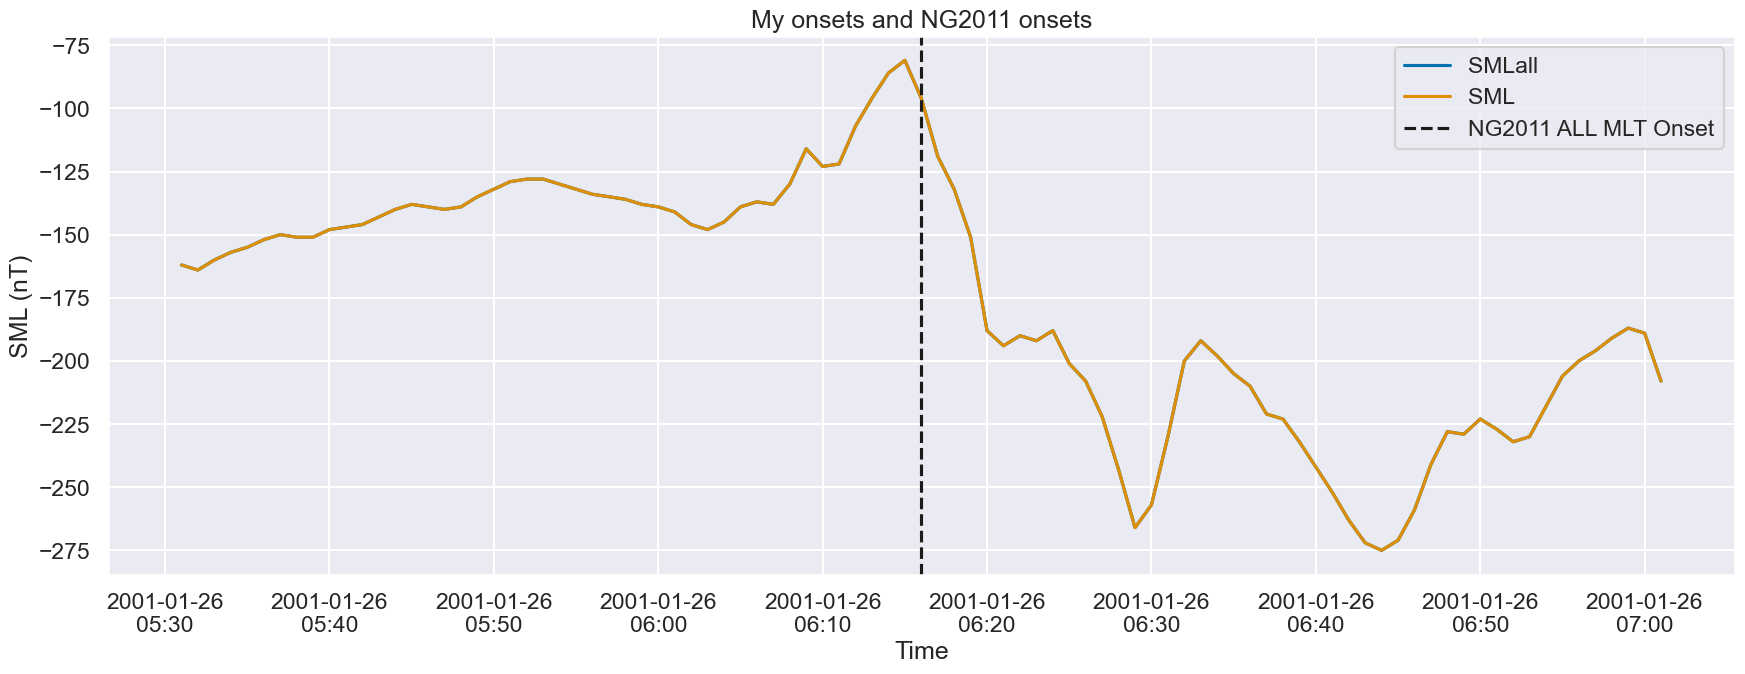

In [103]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_all['Date_UTC'], ng2011_2001['Date_UTC'])[0]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLalldf['Date_UTC'][SMLalldf['Date_UTC'].between(tstart,tend)]
y = SMLalldf['SMLall'][SMLalldf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLall')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k',ls='--',label='NG2011 ALL MLT Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('My onsets and NG2011 onsets')
ax.xaxis.set_major_formatter(date_form)

In [104]:
ng2011_all[ng2011_all['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT at onset
87,2001-01-26 06:16:00,"3, 4, 5"


In [105]:
ng2011_2001[ng2011_2001['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT,MLAT,GLON,GLAT
87,2001-01-26 06:15:00,4.31,66.04,314.56,61.16


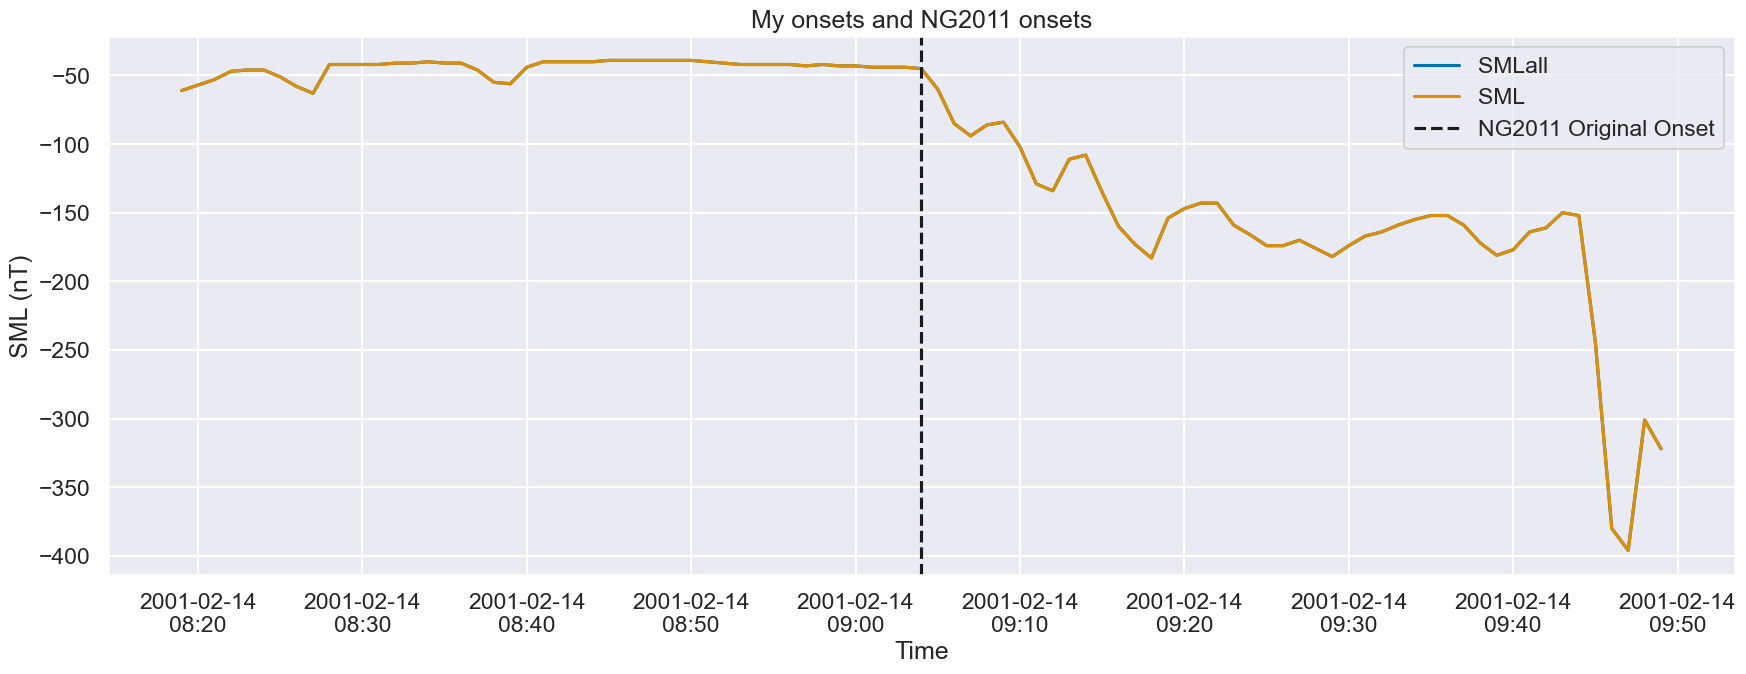

In [100]:
fig,ax = plt.subplots(figsize=(21, 7))

t_diff = np.setdiff1d(ng2011_2001['Date_UTC'], ng2011_all['Date_UTC'])[1]
tstart = t_diff - pd.Timedelta('45 minutes')
tend = t_diff + pd.Timedelta('45 minutes')

x = SMLalldf['Date_UTC'][SMLalldf['Date_UTC'].between(tstart,tend)]
y = SMLalldf['SMLall'][SMLalldf['Date_UTC'].between(tstart,tend)]
x1 = sme_df['Date_UTC'][sme_df['Date_UTC'].between(tstart,tend)]
y1 = sme_df['SML'][sme_df['Date_UTC'].between(tstart,tend)]

ax.plot(x,y,label='SMLall')
ax.plot(x1,y1,label='SML')
ax.axvline(pd.to_datetime(t_diff),c='k', ls='--', label='NG2011 Original Onset')
ax.set_xlabel('Time')
ax.set_ylabel('SML (nT)')
ax.legend()
ax.set_title('My onsets and NG2011 onsets')
ax.xaxis.set_major_formatter(date_form)

In [101]:
ng2011_all[ng2011_all['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT at onset
153,2001-02-14 09:44:00,"1, 2, 3"


In [102]:
ng2011_2001[ng2011_2001['Date_UTC'].between(tstart,tend)]

,Date_UTC,MLT,MLAT,GLON,GLAT
153,2001-02-14 09:04:00,6.89,72.99,309.28,67.02
154,2001-02-14 09:44:00,22.95,66.10,220.89,64.05


Realisation: Newell onset list taking onset location station as not the contributing station to SML at time of onset.